# Kernel $k$-means

In [2]:
from copy import deepcopy
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.decomposition import PCA

from kkmeans import rbf_kernel, kkmeans
from functools import partial


import pickle
import pandas as pd

### Theory | Time & Space Complexity of the implementation

#### Time Complexity

* rbf_kernel: pairwise distance between all pairs of the n_samples in d dimensions -> O(n^2 * d)
* rand_cluster_assignment: O(n)
* kmeans_plusplus: calculating pairwise distance k times -> O(n^2 * k)
* kkmeans: For I iterations:
    * For k clusters:
        * reates the mask, computes K_XX, and K_X. If mask contains all values every usage of K_XX and K_X turn into O(n^2). -> O(n^2*k) for whole loop
        * dist_matrix computation = O(n*k).
    * new_cluster_assignments with argmin = O(n*k).  
    * new_obj_value = O(n) .

Total complexity = O(I* (n^2*k + n*k + n*k +n)) -> O(I*n^2*k).

#### Space Complexity
The space complexity is largely due to the storage of kernel_matrix (n x n -> O(n^2)) and dist_matrix (n x k -> O(nk)). The other variables take linear space => Total space complexity O(n^2 + nk).

## Visualizing the space transformation
The Kernel K-means algorithm is an iterative method that clusters data points $x_i \in \Re^n$ into k distinct groups $\pi_k$. This is achieved by implicitly mapping the data points to a higher-dimensional feature space $H$ through a nonlinear transformation $\Phi$ and minimizing the within-cluster scatter.

This implementation chooses the rbf kernel as a default. However, due to the taylor expansion of the exponential function this is equivalent to a dot product in an infinite space. Since the explicit calculation of the transformation $\phi(x)$ is therefore not feasable, we will look at an explicit transofmration $\phi: \Re^2 \mapsto \Re^3$ from the polynomial kernel $K(x,y) = (x^\mathsf{T} y + c)^{d}$.

$\phi(x) = [\sqrt{2}x_1x_2, x_1^2, x_2^2]^\mathsf{T}$

In [11]:
def phi(X):
    return -np.vstack((np.sqrt(2) * X[:,0] * X[:,1], X[:,0]**2, X[:,1]**2)).T

In [12]:
data_set, labels = make_circles(1000, factor=.1, noise=.01, random_state = 0)
transformed = phi(data_set)

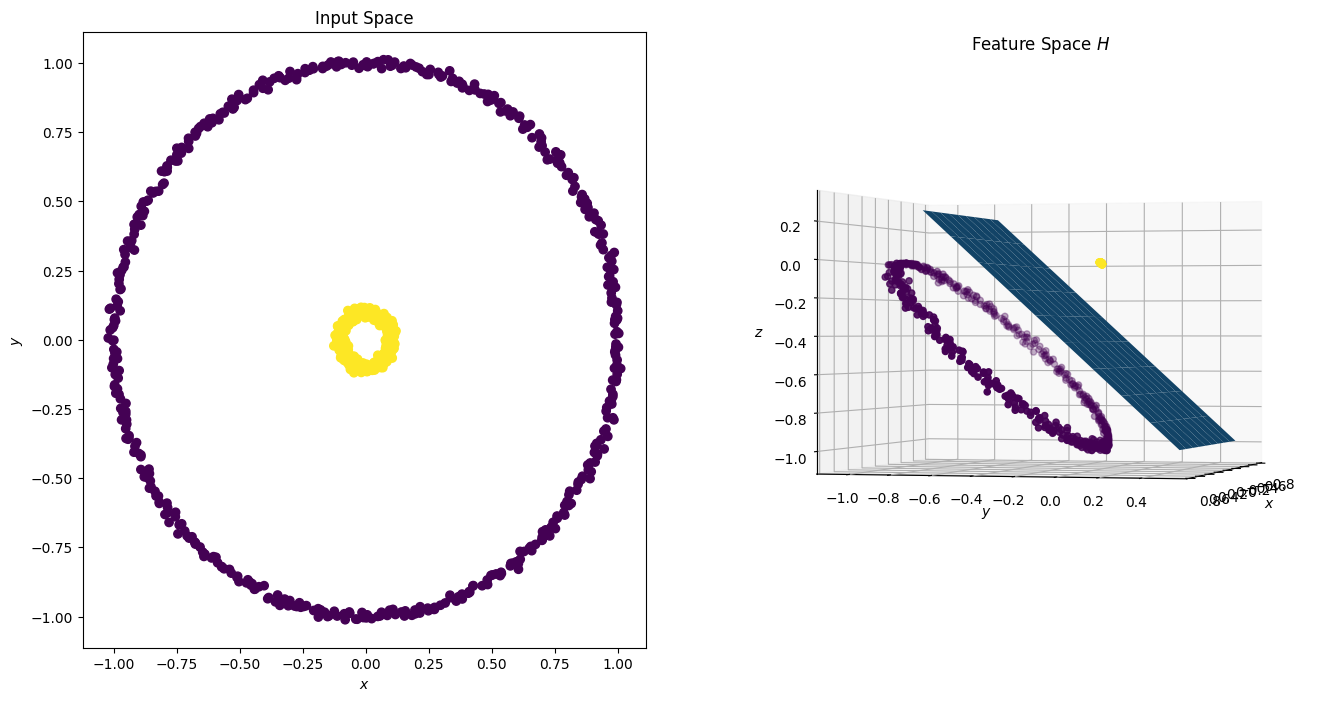

In [13]:
# 2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_set[:,0], data_set[:,1], c=labels, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Input Space')

# 3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(transformed[:,0], transformed[:,1], transformed[:,2],c=labels, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Feature Space $H$')


clf = svm.SVC(kernel='linear')
clf.fit(transformed, labels)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-.75,.5, 10)
xx,yy = np.meshgrid(tmp,tmp)
ax.plot_surface(xx, yy, z(xx,yy), alpha=1)
ax.view_init(0, 15)


plt.show()

# Benchmarking

In [126]:
def df_results(scores_result, index_levels):
    df_list = []

    # Iterate over each unique combination of dataset characteristics
    for i in range(len(scores_result['n_samples'])):
        n_samples = scores_result['n_samples'][i]
        n_features = scores_result['n_features'][i]
        n_clusters = scores_result['n_clusters'][i]

        # Create a temporary DataFrame for each algorithm
        for algo in ['agglo', 'spectral', 'gmm', 'kkmeans']:
            df_temp = pd.DataFrame(scores_result[algo]).iloc[i].to_frame().T  # Get the i-th row of each algorithm
            df_temp['Algorithm'] = algo
            df_temp['n_samples'] = n_samples
            df_temp['n_features'] = n_features
            df_temp['n_clusters'] = n_clusters
            df_list.append(df_temp)

    # Concatenate all the DataFrames
    df = pd.concat(df_list)

    # Set a multi-index (n_samples, n_features, n_clusters, Algorithm)
    df.set_index(['n_samples', 'n_features', 'n_clusters', 'Algorithm'], inplace=True)

    # Reorder the index levels
    df = df.reorder_levels(index_levels)
    
    return df

In [127]:
def df_gradients(x):
    scores_dict = {'silhouette': 0, 'calinski': 0, 'davies': 0, 'sum_of_vars': 0}
    gradients = {'agglo': deepcopy(scores_dict),
                 'spectral': deepcopy(scores_dict),
                 'gmm': deepcopy(scores_dict),
                 'kkmeans': deepcopy(scores_dict)}

    for algo in gradients.keys():
        for score in scores_dict.keys():
            y = scores_result[algo][score]
            a, b = np.polyfit(x, y, 1)
            gradients[algo][score] = a


    df = pd.DataFrame.from_dict(gradients, orient='index')
    pd.set_option('display.float_format', '{:.4e}'.format)
    
    return df

## Benchmarking - Datasize

With a fixed amount of clusters and a fixed dimension, run all algorithms for different data set sizes.

In [125]:
with open('scenario-1-results.pickle', 'rb') as f:
    scores_result = pickle.load(f)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 12500, 15000, 17500, 19000, 20000, 25000, 25700]


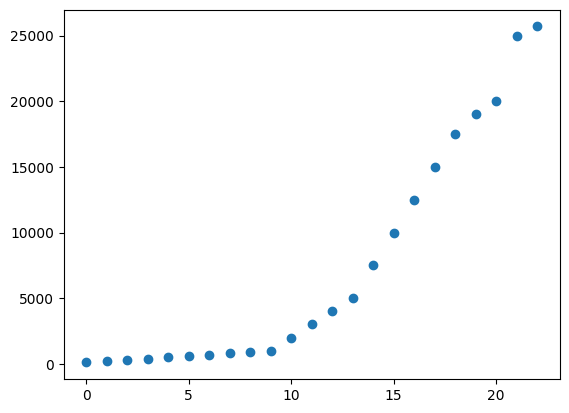

In [17]:
print(scores_result['n_samples'])
plt.scatter(np.arange(0,len(scores_result['n_samples'])), scores_result['n_samples'])
plt.show()

In [128]:
df = df_results(scores_result, ['n_clusters', 'n_features', 'n_samples', 'Algorithm'])
df

silhouette   calinski     davies   
n_clusters n_features n_samples Algorithm                                     
10         3          100       agglo      3.2504e-01 7.2288e+01 8.7818e-01  \
                                spectral   3.2009e-01 7.3282e+01 8.0108e-01   
                                gmm        3.0904e-01 6.9632e+01 8.8880e-01   
                                kkmeans    3.4620e-01 8.0957e+01 8.8135e-01   
14         3          200       agglo      3.0697e-01 1.3564e+02 9.6259e-01   
                                spectral   3.4102e-01 1.5894e+02 8.7560e-01   
                                gmm        3.4387e-01 1.6325e+02 8.9248e-01   
                                kkmeans    3.5126e-01 1.6804e+02 9.0458e-01   
17         3          300       agglo      2.7353e-01 1.7908e+02 8.8669e-01   
                                spectral   3.4353e-01 2.3600e+02 8.7944e-01   
                                gmm        3.3199e-01 2.2048e+02 8.9395e-01   
                                kkmeans    3.4263e-01 2.3574e+02 8.6309e-01   
20         3          400       agglo      2.9607e-01 2.7246e+02 1.0172e+00   
                                spectral   3.3789e-01 3.0093e+02 8.4672e-01   
                                gmm        3.2634e-01 2.9878e+02 8.9236e-01   
                                kkmeans    3.4352e-01 3.1029e+02 9.0767e-01   
22         3          500       agglo      2.6367e-01 3.1859e+02 9.2261e-01   
                                spectral   3.3852e-01 4.0294e+02 8.7410e-01   
                                gmm        3.2588e-01 3.8265e+02 8.9380e-01   
                                kkmeans    3.5116e-01 3.8689e+02 8.5537e-01   
24         3          600       agglo      2.9520e-01 4.0168e+02 8.8954e-01   
                                spectral   3.5101e-01 4.9475e+02 8.5773e-01   
                                gmm        3.4867e-01 4.9057e+02 8.5653e-01   
                                kkmeans    3.4532e-01 4.9233e+02 8.7079e-01   
26         3          700       agglo      2.8266e-01 4.2453e+02 9.5617e-01   
                                spectral   3.4025e-01 5.5884e+02 8.8104e-01   
                                gmm        3.2021e-01 5.3006e+02 9.0590e-01   
                                kkmeans    3.3276e-01 5.4862e+02 8.8957e-01   
28         3          800       agglo      3.0962e-01 5.7992e+02 9.2009e-01   
                                spectral   3.4294e-01 6.6186e+02 8.4892e-01   
                                gmm        3.3458e-01 6.3977e+02 8.7570e-01   
                                kkmeans    3.4019e-01 6.6495e+02 8.6522e-01   
30         3          900       agglo      3.2130e-01 6.8152e+02 9.2614e-01   
                                spectral   3.3874e-01 7.4274e+02 8.7020e-01   
                                gmm        3.3596e-01 7.0819e+02 8.9317e-01   
                                kkmeans    3.3758e-01 7.3956e+02 8.7863e-01   
31         3          1000      agglo      2.7504e-01 6.4181e+02 8.6561e-01   
                                spectral   3.3613e-01 7.8169e+02 8.7389e-01   
                                gmm        3.3532e-01 7.7527e+02 8.8047e-01   
                                kkmeans    3.2900e-01 7.7000e+02 8.9941e-01   
44         3          2000      agglo      3.0911e-01 1.3614e+03 8.8365e-01   
                                spectral   3.3601e-01 1.5926e+03 8.8377e-01   
                                gmm        3.3155e-01 1.5519e+03 8.9251e-01   
                                kkmeans    3.3582e-01 1.5954e+03 8.8649e-01   
54         3          3000      agglo      2.6991e-01 1.8974e+03 9.5031e-01   
                                spectral   3.3570e-01 2.3998e+03 8.7083e-01   
                                gmm        3.2847e-01 2.3122e+03 9.1143e-01   
                                kkmeans    3.3516e-01 2.4068e+03 8.7382e-01   
63         3          4000      agglo      2.9991e-01 2.7001e+03 9.2414e-01   
              

In [131]:
means = df.groupby('Algorithm').mean()
stds = df.groupby('Algorithm').std()

#df_combined = means.round(3).astype(str) + " ± " + stds.round(3).astype(str)
df_combined = means.applymap(partial("{:.2e}".format)) + " ± " + stds.applymap(partial("{:.2e}".format)) 


df_combined

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
agglo,2.91e-01 ± 1.63e-02,4.77e+03 ± 5.52e+03,9.38e-01 ± 4.65e-02,2.58e+00 ± 1.28e-01
gmm,3.30e-01 ± 7.61e-03,5.82e+03 ± 6.81e+03,8.91e-01 ± 1.06e-02,2.41e+00 ± 5.76e-02
kkmeans,3.36e-01 ± 8.85e-03,5.85e+03 ± 6.82e+03,8.82e-01 ± 1.50e-02,2.38e+00 ± 5.57e-02
spectral,3.35e-01 ± 6.69e-03,5.86e+03 ± 6.83e+03,8.74e-01 ± 1.98e-02,2.36e+00 ± 6.55e-02


In [20]:
medians = df.groupby('Algorithm').median()
medians.applymap(partial("{:.2e}".format))

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
agglo,2.88e-01,1.90e+03,9.37e-01,2.59e+00
gmm,3.28e-01,2.31e+03,8.92e-01,2.42e+00
kkmeans,3.33e-01,2.41e+03,8.85e-01,2.40e+00
spectral,3.34e-01,2.40e+03,8.81e-01,2.38e+00


In [21]:
min_vals = df.groupby('Algorithm').min()
max_vals = df.groupby('Algorithm').max()

max_vals - min_vals

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
agglo,0.061371,15935.077753,0.198519,0.522163
gmm,0.039633,20106.833651,0.054899,0.268583
kkmeans,0.028830,20212.971065,0.065251,0.196862
spectral,0.030928,20209.537102,0.088966,0.252827


In [22]:
means.nlargest(2,['silhouette'])

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
kkmeans,0.336446,5852.103947,0.881752,2.380056
spectral,0.334642,5861.471238,0.873940,2.360814


In [23]:
df_gradients(np.array(scores_result['n_samples']).astype(int)).applymap(partial("{:.2e}".format))

,silhouette,calinski,davies,sum_of_vars
agglo,-4.70e-07,6.34e-01,2.04e-06,9.91e-06
spectral,-3.96e-07,7.84e-01,1.09e-06,5.03e-06
gmm,-1.03e-07,7.82e-01,1.55e-08,1.71e-06
kkmeans,-5.36e-07,7.83e-01,1.53e-07,3.54e-06


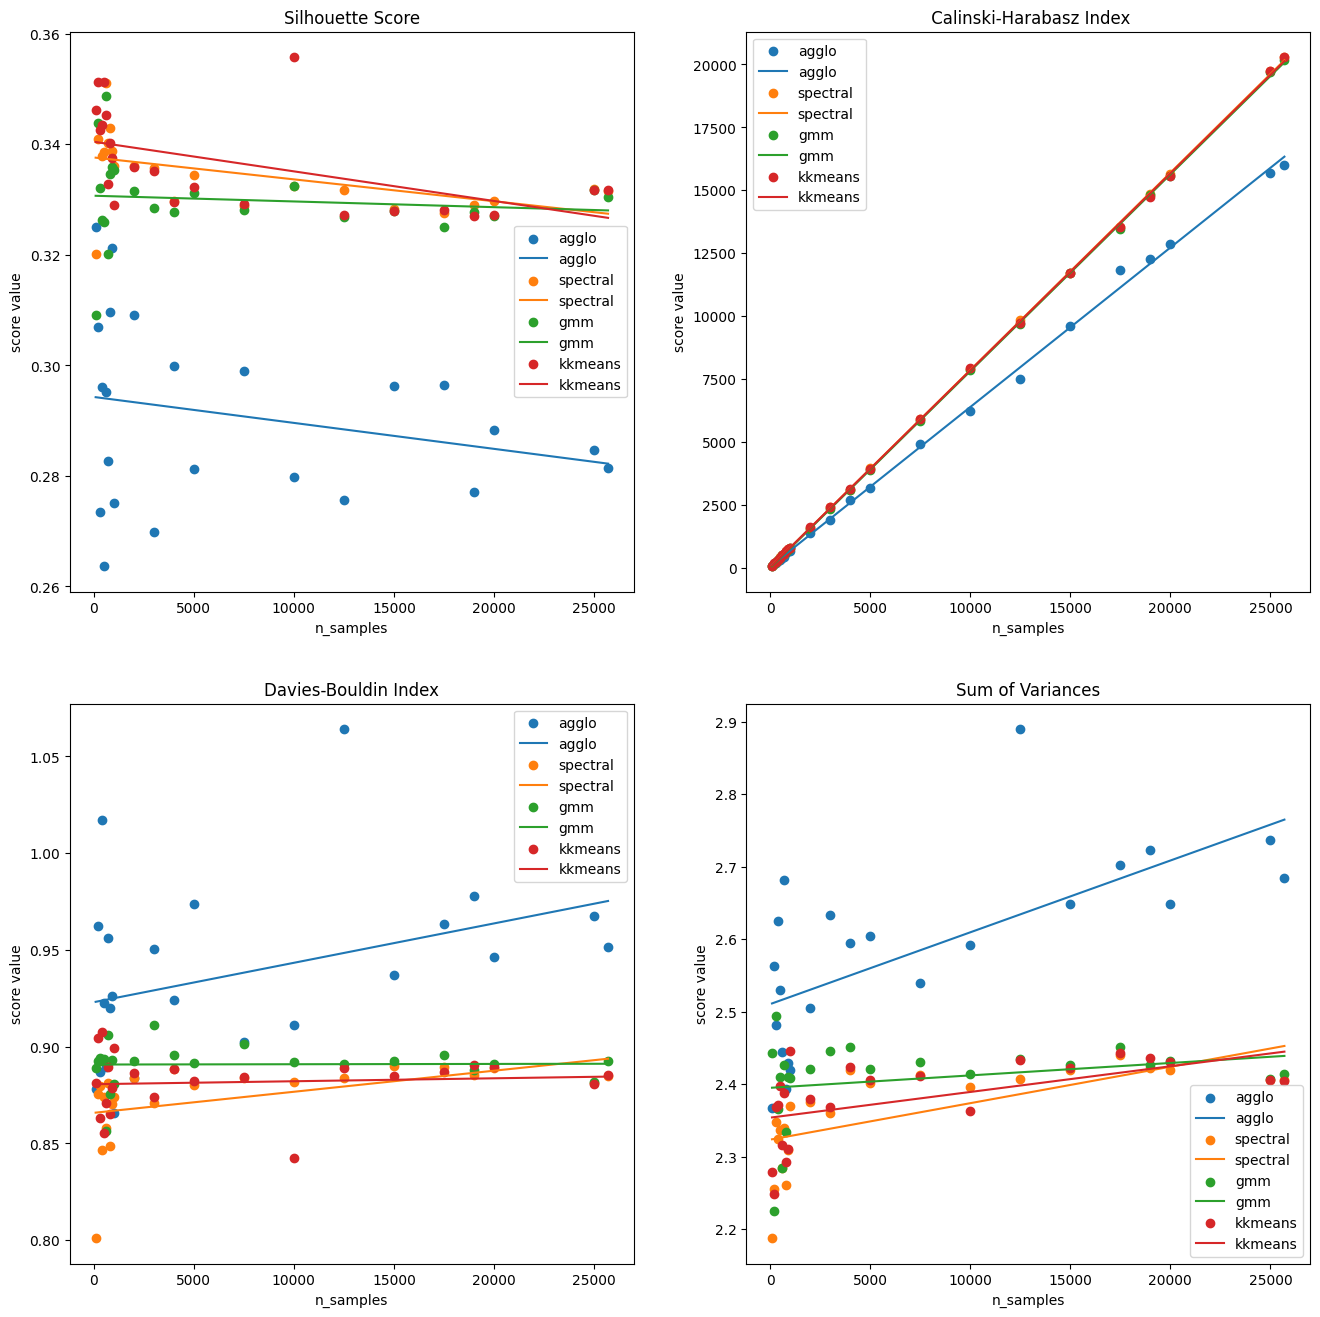

In [24]:
x = np.array(scores_result['n_samples']).astype(int)

_, axs = plt.subplots(2, 2, figsize=(16, 16))
plots = [
    (axs[0,0], 'silhouette', 'Silhouette Score'),
    (axs[0,1], 'calinski', ' Calinski-Harabasz Index'),
    (axs[1,0], 'davies', 'Davies-Bouldin Index'),
    (axs[1,1], 'sum_of_vars', 'Sum of Variances')
]
for ax, score, title in plots:
    for algo in ['agglo', 'spectral', 'gmm', 'kkmeans']:
        y = scores_result[algo][score]
        a, b = np.polyfit(x, y, 1)
        ax.scatter(x, y, label=algo)
        ax.plot(x, a*x+b, label=algo)
        ax.set_title(title)
        ax.set_ylabel("score value")
        ax.set_xlabel("n_samples")
        ax.legend()

## Benchmarking - Dimensions

With a fixed amount of clusters and a fixed amount of data points, run all algorithms on different dimensions.

In [133]:
with open('scenario-2-results.pickle', 'rb') as f:
    scores_result = pickle.load(f)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600]


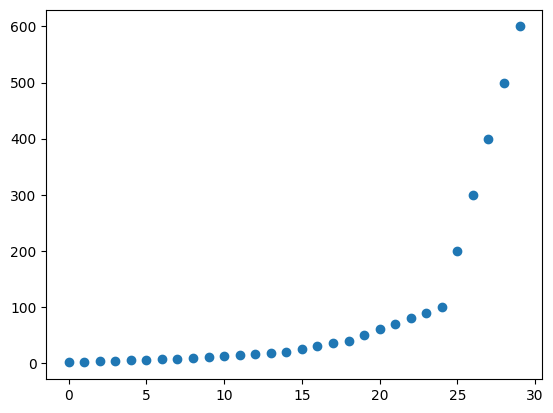

In [134]:
print(scores_result['n_features'])
plt.scatter(np.arange(0,len(scores_result['n_features'])), scores_result['n_features'])
plt.show()

In [135]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4e}'.format)
df = df_results(scores_result, ['n_clusters', 'n_samples', 'n_features', 'Algorithm'])
df

silhouette   calinski     davies   
n_clusters n_samples n_features Algorithm                                     
5          500       1          agglo      5.8539e-01 3.4995e+03 4.3387e-01  \
                                spectral   5.4106e-01 2.3278e+03 5.6434e-01   
                                gmm        6.3553e-01 4.4324e+03 4.2652e-01   
                                kkmeans    6.2966e-01 3.3272e+03 4.4053e-01   
                     2          agglo      5.5415e-01 1.8227e+03 5.9899e-01   
...                                               ...        ...        ...   
                     500        kkmeans    6.2451e-01 4.2281e+02 7.7535e-01   
                     600        agglo      7.8552e-01 2.1776e+03 3.0912e-01   
                                spectral   7.8552e-01 2.1776e+03 3.0912e-01   
                                gmm        7.8552e-01 2.1776e+03 3.0912e-01   
                                kkmeans    7.8552e-01 2.1776e+03 3.0912e-01   

                                           sum_of_vars  
n_clusters n_samples n_features Algorithm               
5          500       1          agglo       1.4893e-01  
                                spectral    1.8227e-01  
                                gmm         1.3479e-01  
                                kkmeans     1.7903e-01  
                     2          agglo       6.3059e-01  
...                                                ...  
                     500        kkmeans     3.9244e+02  
                     600        agglo       1.6132e+02  
                                spectral    1.6132e+02  
                                gmm         1.6132e+02  
                                kkmeans     1.6132e+02  

[120 rows x 4 columns]

In [136]:
means = df.groupby('Algorithm').mean()
stds = df.groupby('Algorithm').std()

df_combined = means.applymap(partial("{:.2e}".format)) + " ± " + stds.applymap(partial("{:.2e}".format)) 


df_combined

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
agglo,7.55e-01 ± 6.85e-02,2.47e+03 ± 5.84e+02,3.47e-01 ± 8.89e-02,2.34e+01 ± 4.16e+01
gmm,7.55e-01 ± 6.91e-02,2.49e+03 ± 6.89e+02,3.65e-01 ± 1.61e-01,2.34e+01 ± 4.16e+01
kkmeans,6.57e-01 ± 1.11e-01,1.33e+03 ± 1.07e+03,6.35e-01 ± 3.08e-01,5.00e+01 ± 8.83e+01
spectral,7.44e-01 ± 8.58e-02,2.38e+03 ± 6.69e+02,3.74e-01 ± 1.47e-01,2.42e+01 ± 4.16e+01


In [29]:
medians = df.groupby('Algorithm').median()
medians.applymap(partial("{:.2e}".format))

,silhouette,calinski,davies,sum_of_vars
Algorithm,,,,
agglo,7.85e-01,2.39e+03,3.10e-01,5.54e+00
gmm,7.85e-01,2.39e+03,3.10e-01,5.54e+00
kkmeans,6.30e-01,7.88e+02,6.51e-01,8.18e+00
spectral,7.85e-01,2.38e+03,3.10e-01,5.54e+00


In [30]:
df_gradients(np.array(scores_result['n_features']).astype(int)).applymap(partial("{:.2e}".format))

,silhouette,calinski,davies,sum_of_vars
agglo,1.19e-04,-6.70e-01,-1.51e-04,2.68e-01
spectral,1.41e-04,-4.16e-01,-2.07e-04,2.66e-01
gmm,1.19e-04,-7.41e-01,-2.16e-04,2.68e-01
kkmeans,1.47e-04,-1.74e-01,-2.46e-04,4.80e-01


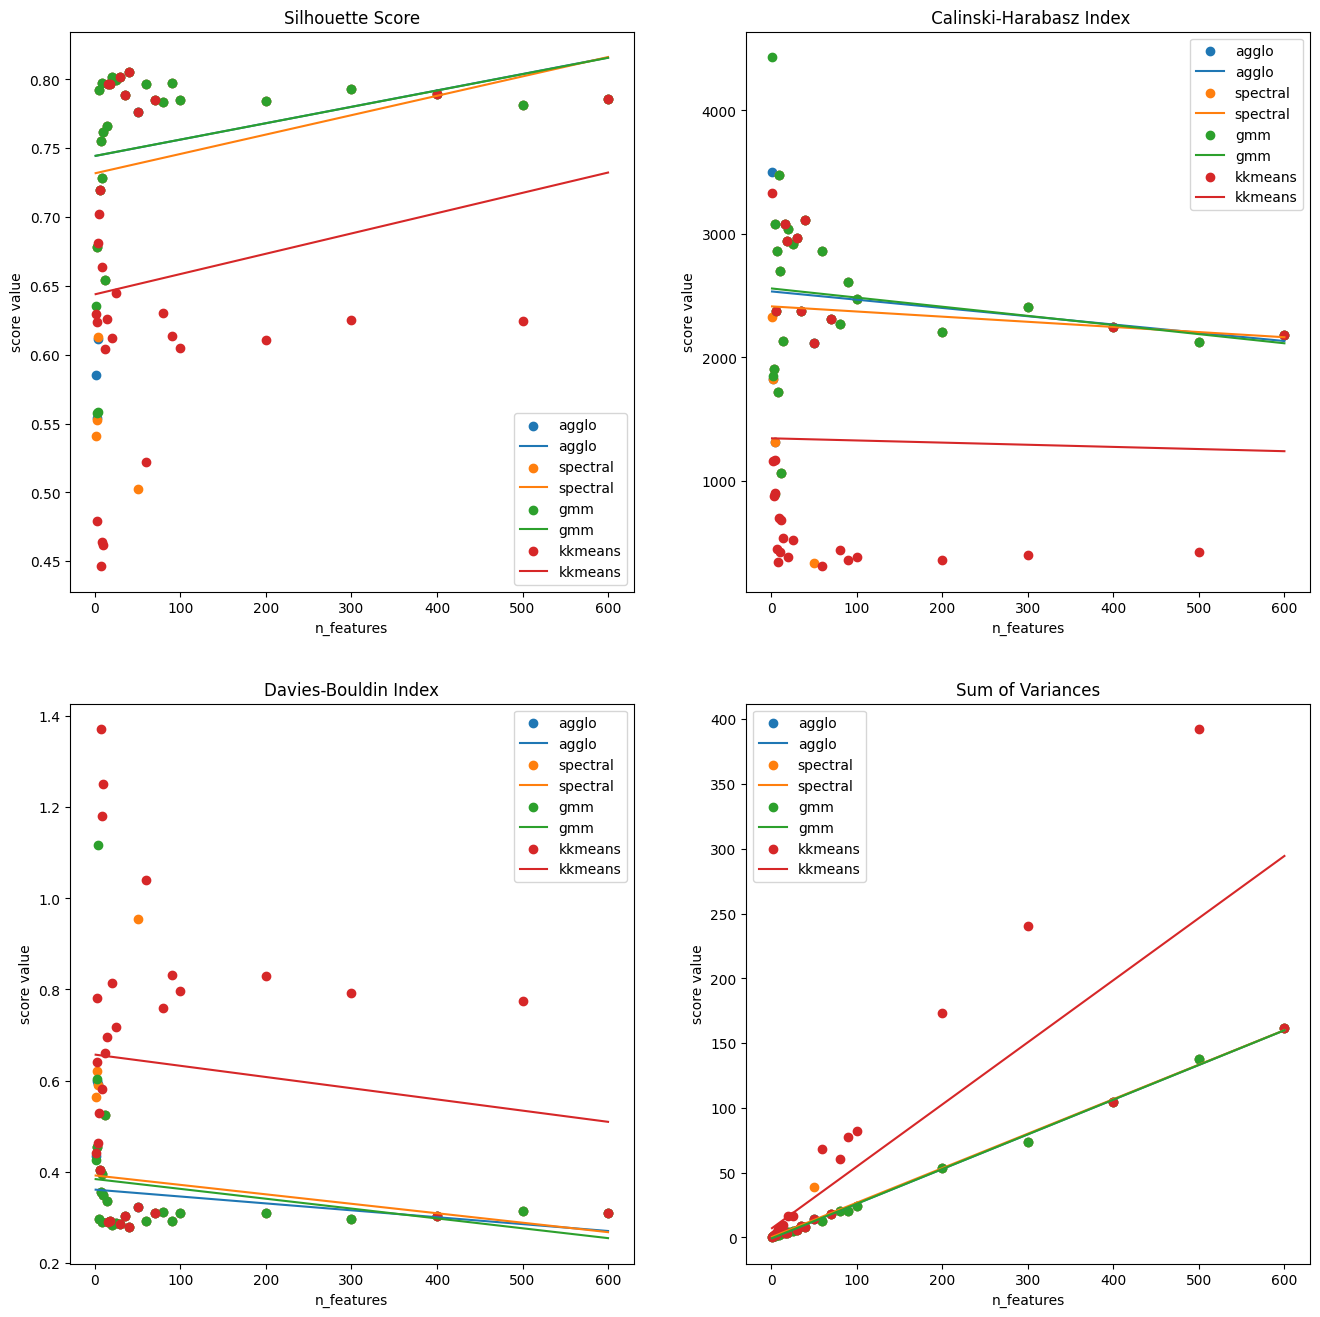

In [31]:
x = np.array(scores_result['n_features']).astype(int)

_, axs = plt.subplots(2, 2, figsize=(16, 16))
plots = [
    (axs[0,0], 'silhouette', 'Silhouette Score'),
    (axs[0,1], 'calinski', ' Calinski-Harabasz Index'),
    (axs[1,0], 'davies', 'Davies-Bouldin Index'),
    (axs[1,1], 'sum_of_vars', 'Sum of Variances')
]
for ax, score, title in plots:
    for algo in ['agglo', 'spectral', 'gmm', 'kkmeans']:
        y = scores_result[algo][score]
        a, b = np.polyfit(x, y, 1)
        ax.scatter(x, y, label=algo)
        ax.plot(x, a*x+b, label=algo)
        ax.set_title(title)
        ax.set_ylabel("score value")
        ax.set_xlabel("n_features")
        ax.legend()

## Qualitative QA

In [32]:
FONT_SIZE = 8


def plot_1D_scatter(axs):
    n_clusters = 3
    X, _ = make_blobs(n_samples=300, centers=n_clusters, n_features=1, random_state=42)
    cluster_assignments = kkmeans(X, n_clusters=n_clusters)

    axs.scatter(X[:, 0], np.zeros_like(X), c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('1D Blobs', fontsize=FONT_SIZE)

def plot_2D_scatter(axs):
    n_clusters = 4
    X, _ = make_blobs(n_samples=100, centers=n_clusters, cluster_std=0.60)
    cluster_assignments = kkmeans(X, n_clusters)

    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title("2D Blobs", fontsize=FONT_SIZE)

def plot_5D_reduced_scatter(axs):
    n_features = 5
    n_clusters = 3
    X, _ = make_blobs(n_samples=300, centers=n_clusters, n_features=n_features, random_state=42)
    cluster_assignments = kkmeans(X, n_clusters=n_clusters)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    axs.scatter(X_pca[:, 0], X_pca[:, 1],
                c=cluster_assignments, cmap='viridis', marker='o')
    axs.set_title(f'{n_features}D Blobs. Post clustering reduction\nto 2D using PCA.',
                  fontsize=FONT_SIZE)

def plot_2D_circles(axs):
    X, _ = make_circles(n_samples=1_000, factor=0.1,
                        noise=0.05, random_state=0)
    cluster_assignments = kkmeans(
        X, n_clusters=2, kernel_function=lambda X: rbf_kernel(X, sigma=0.4))

    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('2D circles', fontsize=FONT_SIZE)

    
def plot_2D_moons(axs):
    X, _ = make_moons(n_samples=1000, noise=0.1)
    cluster_assignments = kkmeans(X, n_clusters=2, kernel_function=lambda X: rbf_kernel(X, sigma=0.5))

    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('2D moons', fontsize=FONT_SIZE)

def plot_2D_rand(axs):
    X = np.random.rand(500, 2)
    cluster_assignments = kkmeans(X, n_clusters=3)

    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('2D random', fontsize=FONT_SIZE)
    
def plot_2D_ansio(axs):
    random_state = 170
    X, _ = make_blobs(n_samples=500, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X = np.dot(X, transformation)
    cluster_assignments = kkmeans(X, n_clusters=3)
    
    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('2D anisotropicly distributed blobs', fontsize=FONT_SIZE)
    

def plot_2D_diff_var_blobs(axs):
    X, _ = make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=170)
    cluster_assignments = kkmeans(X, n_clusters=3)

    
    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o')
    axs.set_title('2D blobs with different variances', fontsize=FONT_SIZE)
    
    
def plot_large_data_set(axs):
    n_samples=5000
    X, _ = make_blobs(n_samples=n_samples, centers=3, random_state=42)
    cluster_assignments = kkmeans(X, n_clusters=3)

    axs.scatter(X[:, 0], X[:, 1], c=cluster_assignments,
                cmap='viridis', marker='o', s=5, alpha=0.5)
    axs.set_title(f'2D large dataset (n_samples={n_samples})', fontsize=FONT_SIZE)

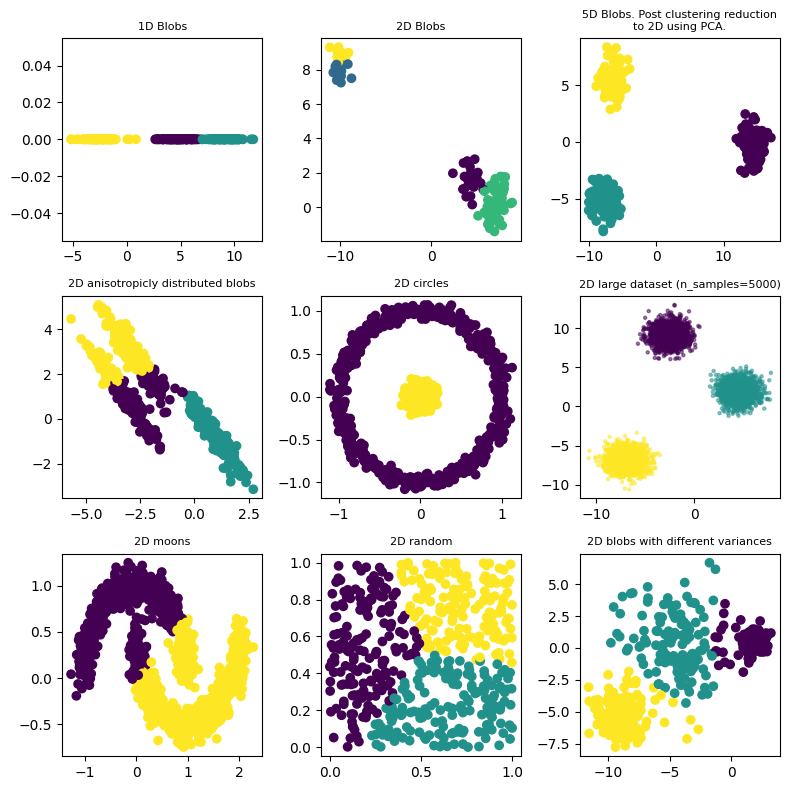

In [33]:
_, axs = plt.subplots(3, 3, figsize=(8, 8))

plot_1D_scatter(axs[0, 0])
plot_2D_scatter(axs[0, 1])
plot_5D_reduced_scatter(axs[0, 2])

plot_2D_circles(axs[1, 1])
plot_2D_ansio(axs[1,0])
plot_large_data_set(axs[1, 2])

plot_2D_moons(axs[2,0])
plot_2D_rand(axs[2,1])
plot_2D_diff_var_blobs(axs[2,2])


plt.tight_layout()
plt.show()

## Comparison - Cluster Initialization

In [137]:
from kkmeans import kmeans_plusplus
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [138]:
def sum_of_variances(X, labels):
    unique_labels = np.unique(labels)
    sum_of_vars = 0
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        var = np.mean(np.sum((cluster_points - centroid) ** 2, axis=1))
        sum_of_vars += var
    return sum_of_vars

In [121]:
n_samples = 1000
n_features = 3
n_clusters = 5

rand_silhouette_scores = []
rand_calinski_scores = []
rand_davies_scores = []
rand_sum_of_vars_scores = []

kmpp_silhouette_scores = []
kmpp_calinski_scores = []
kmpp_davies_scores = []
kmpp_sum_of_vars_scores = []


scaler = StandardScaler()

for i in range(0, 200):
    X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)
    X_scaled = scaler.fit_transform(X)
    
    clusters_rand = kkmeans(X, n_clusters=n_clusters)
    clusters_kmplusplus = kkmeans(X, n_clusters=n_clusters, initial_cluster_assignments=kmeans_plusplus)
    
    rand_silhouette_scores.append(silhouette_score(X, clusters_rand))
    rand_calinski_scores.append(calinski_harabasz_score(X, clusters_rand))
    rand_davies_scores.append(davies_bouldin_score(X, clusters_rand))
    rand_sum_of_vars_scores.append(sum_of_variances(X, clusters_rand))

    kmpp_silhouette_scores.append(silhouette_score(X, clusters_kmplusplus))
    kmpp_calinski_scores.append(calinski_harabasz_score(X, clusters_kmplusplus))
    kmpp_davies_scores.append(davies_bouldin_score(X, clusters_kmplusplus))
    kmpp_sum_of_vars_scores.append(sum_of_variances(X, clusters_kmplusplus))

In [140]:
def format_res(vals):
    return f"{vals.mean():.2e} ± {vals.std():.2e}"


data = [
    {
        "silhouette": format_res(np.array(rand_silhouette_scores)),
        "calinski": format_res(np.array(rand_calinski_scores)),
        "davies": format_res(np.array(rand_davies_scores)),
        "sum_of_vars": format_res(np.array(rand_sum_of_vars_scores))
    },
    {                                                      
        "silhouette": format_res(np.array(kmpp_silhouette_scores)),
        "calinski": format_res(np.array(kmpp_calinski_scores)),
        "davies": format_res(np.array(kmpp_davies_scores)),
        "sum_of_vars": format_res(np.array(kmpp_sum_of_vars_scores))
    }
]


pd.DataFrame(data, index=["random", "kmeans++"])

,silhouette,calinski,davies,sum_of_vars
random,6.31e-01 ± 8.66e-02,3.32e+03 ± 2.13e+03,6.04e-01 ± 2.17e-01,3.15e+01 ± 2.05e+01
kmeans++,6.69e-01 ± 9.28e-02,5.82e+03 ± 2.46e+03,5.75e-01 ± 2.55e-01,1.70e+01 ± 4.95e+00


In [143]:
def format_res_medians(vals):
    return f"{np.median(vals):.2e}"


data = [
    {
        "silhouette": format_res_medians(np.array(rand_silhouette_scores)),
        "calinski": format_res_medians(np.array(rand_calinski_scores)),
        "davies": format_res_medians(np.array(rand_davies_scores)),
        "sum_of_vars": format_res_medians(np.array(rand_sum_of_vars_scores))
    },
    {                                                      
        "silhouette": format_res_medians(np.array(kmpp_silhouette_scores)),
        "calinski": format_res_medians(np.array(kmpp_calinski_scores)),
        "davies": format_res_medians(np.array(kmpp_davies_scores)),
        "sum_of_vars": format_res_medians(np.array(kmpp_sum_of_vars_scores))
    }
]


pd.DataFrame(data, index=["random", "kmeans++"])

,silhouette,calinski,davies,sum_of_vars
random,6.27e-01,2.63e+03,5.61e-01,2.41e+01
kmeans++,6.76e-01,5.93e+03,4.72e-01,1.50e+01


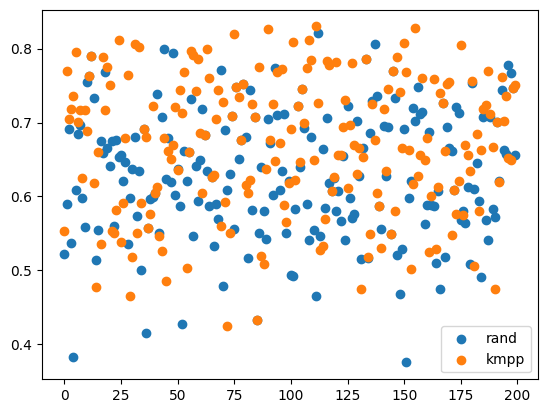

In [141]:
X = range(0, len(rand_silhouette_scores))
plt.scatter(X, rand_silhouette_scores, label="rand")
plt.scatter(X, kmpp_silhouette_scores, label="kmpp")
plt.legend()

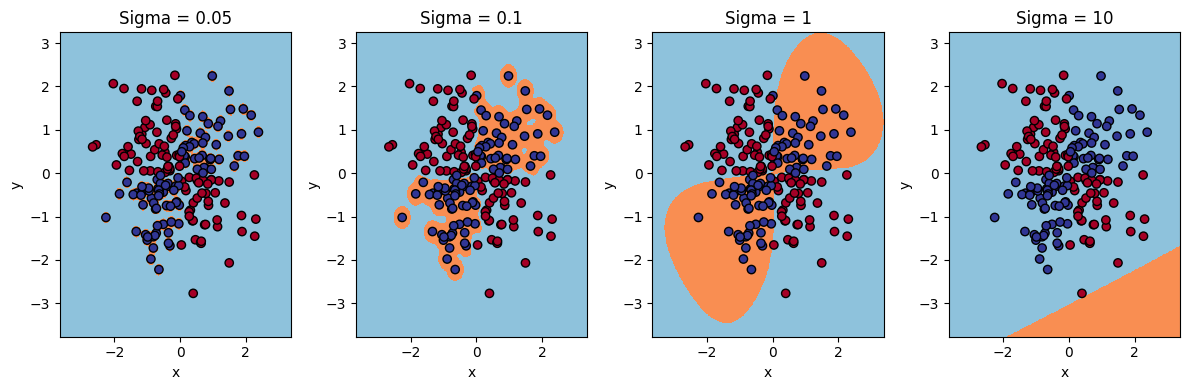

In [4]:
# Generate synthetic data for demonstration
np.random.seed(0)
X = np.random.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# Fit SVM with different sigma values
sigmas = [0.05, 0.1, 1, 10]
plt.figure(figsize=(12, 4))
for i, sigma in enumerate(sigmas):
    model = svm.SVC(kernel='rbf', gamma=1/(2*sigma**2))
    model.fit(X, y)

    # Create a meshgrid of points to evaluate the decision boundary
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.subplot(1, 4, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu_r, edgecolors='k')
    plt.title(f'Sigma = {sigma}')
    plt.xlabel('x')
    plt.ylabel('y')

plt.tight_layout()
plt.show()